# Idea

1) 만약 삐꾸가 데이터의 순서에 연관이 있는 거라면 ..?

2) 순서로 정렬해서 조합을 봅시다용

In [129]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import xgboost as xgb
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()
sns.set()

In [130]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

In [198]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.shape, test.shape

((200000, 202), (200000, 201))

## 피처 추가

In [474]:
bbiggu = pd.read_csv('./data_temp/bbiggu_1.csv')

In [483]:
bbiggu.iloc[52387]

ID_code    train_52387
pred           0.16972
bbiggu               0
fold                 3
Name: 52387, dtype: object

In [15]:
col_list = train.columns[2:]

### 순서정보

In [16]:
# for col in tqdm_notebook(col_list):
#     temp = train.sort_values(col).ID_code.to_frame()
#     temp['order'] = range(len(temp))
#     train['order_' + col] = train.ID_code.map(temp.set_index(temp.ID_code).order)    

### 번째정보

In [17]:
# for col in tqdm_notebook([col for col in train.columns if "order" in col]):
#     train['on_2_' + col.replace("order_", "")] = (train[col] % 2 == 0) * 1

In [18]:
# for col in tqdm_notebook([col for col in train.columns if "order" in col]):
#     train['on_3_' + col.replace("order_", "")] = (train[col] % 3 == 0) * 1

In [19]:
# for col in tqdm_notebook([col for col in train.columns if "order" in col]):
#     train['on_5_' + col.replace("order_", "")] = (train[col] % 5 == 0) * 1

## Modeling

In [20]:
target = train['target']

In [21]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [22]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
# predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
#     predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921561	valid_1's auc: 0.896028
[6000]	training's auc: 0.93604	valid_1's auc: 0.899441
Early stopping, best iteration is:
[6067]	training's auc: 0.936302	valid_1's auc: 0.899503
CV score: 0.89950 
fold n°1
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921516	valid_1's auc: 0.897313
[6000]	training's auc: 0.935852	valid_1's auc: 0.899958
Early stopping, best iteration is:
[6330]	training's auc: 0.937156	valid_1's auc: 0.900005
CV score: 0.90000 
fold n°2
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.92043	valid_1's auc: 0.902095
[6000]	training's auc: 0.934863	valid_1's auc: 0.905863
Early stopping, best iteration is:
[6644]	training's auc: 0.937438	valid_1's auc: 0.906232
CV score: 0.90623 
fold n°3
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921865	valid_1's auc: 0

# Idea

* 컬럼별 순서가 변경돼도 되면, 정렬해도 되지 않을까?

## 모듈 & 데이터 로드

In [159]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import xgboost as xgb
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()
sns.set()

In [160]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

In [161]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.shape, test.shape

((200000, 202), (200000, 201))

In [341]:
# train_raw = train.copy()

In [439]:
train = train_raw.copy()

In [440]:
col_list = train.columns[2:]

In [441]:
train_0 = train[train.target == 0].copy()
train_1 = train[train.target == 1].copy()

In [442]:
for col in tqdm_notebook(['var_1', 'var_2', 'var_3', 'var_5', 'var_18', 'var_10', 'var_13', 'var_14']):
    train_0[col] = train_0[col].sort_values().values
    train_1[col] = train_1[col].sort_values().values

In [443]:
# for col in tqdm_notebook(['var_4', 'var_6', 'var_7', 'var_9', 'var_11', 'var_12', 'var_18', 'var_20']):
#     train_0[col] = train_0[col].sort_values().values
#     train_1[col] = train_1[col].sort_values().values

In [444]:
train = train_0.append(train_1).sort_index()

In [445]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-15.0434,2.1171,-0.0402,11.4607,-32.5626,5.1187,18.6266,-4.9200,5.7470,-20.7313,3.1821,14.0137,-6.0111,1.1690,14.5691,5.7487,-7.2393,-10.6642,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-14.6962,2.1693,0.0162,12.3622,-30.6816,5.6208,16.5338,3.1468,8.0851,-19.4439,8.0585,14.0239,-4.9874,1.2167,13.7003,13.8275,-15.5849,-9.8861,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.

In [446]:
target = train['target']

In [447]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [448]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[165]	training's auc: 0.960367	valid_1's auc: 0.953462
CV score: 0.95346 
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[165]	training's auc: 0.945831	valid_1's auc: 0.939523
CV score: 0.93952 
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[165]	training's auc: 0.957411	valid_1's auc: 0.953038
CV score: 0.95304 
fold n°3
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: 

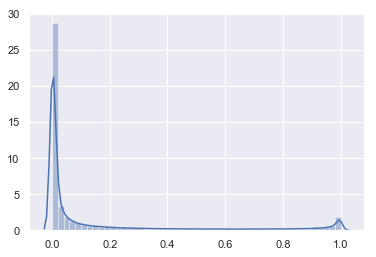

In [111]:
sns.distplot(oof_lgb)

In [43]:
sub = pd.read_csv('./data/sample_submission.csv')

In [47]:
sub.target = predictions_lgb

In [49]:
sub.to_csv('./data/sub_simple_sort.csv', index=False)

# Idea

1) 삐꾸 친구들을 Oversampling

2) 삐꾸 친구들을 Undersampling

3) sorting

## 삐꾸데이터 로드

In [119]:
bbiggu = pd.read_csv('./data_temp/bbiggu_1.csv')

In [120]:
bbiggu_idx = bbiggu[bbiggu.bbiggu == 1].ID_code.values

In [121]:
bbiggu_idx.shape

(3374,)

In [97]:
# 데이터 aug
def aug(data, thres):
    temp = data[data.ID_code.isin(bbiggu_idx)]
    for _ in range(thres):
        data = data.append(temp).reset_index(drop=True)
    gc.collect()
    return data

In [98]:
# 데이터 elim
def elim(data):
    return data[~data.ID_code.isin(bbiggu_idx)]    

In [99]:
# 데이터 sort
def sort(data):
    for col in tqdm_notebook(col_list):
        data[col] = data[col].sort_values().values
    
    return data

## Modeling

In [100]:
target = train['target']

In [101]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [103]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    
    trn_data = train.iloc[trn_idx].copy()
    print(trn_data.shape)
    trn_data = elim(trn_data)
    print(trn_data.shape)
    
    trn_data = lgb.Dataset(trn_data[train_columns], label=trn_data.target.values)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
(159999, 202)
(129128, 202)
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.993148	valid_1's auc: 0.884917
[2000]	training's auc: 0.99722	valid_1's auc: 0.891715
[3000]	training's auc: 0.998759	valid_1's auc: 0.894895
[4000]	training's auc: 0.999471	valid_1's auc: 0.897136
[5000]	training's auc: 0.999803	valid_1's auc: 0.898861
[6000]	training's auc: 0.999924	valid_1's auc: 0.899955
[7000]	training's auc: 0.999975	valid_1's auc: 0.900639
[8000]	training's auc: 0.999991	valid_1's auc: 0.901214
[9000]	training's auc: 0.999997	valid_1's auc: 0.901492
[10000]	training's auc: 0.999999	valid_1's auc: 0.901817
[11000]	training's auc: 1	valid_1's auc: 0.902016
[12000]	training's auc: 1	valid_1's auc: 0.902245
[13000]	training's auc: 1	valid_1's auc: 0.902445
[14000]	training's auc: 1	valid_1's auc: 0.902497
[15000]	training's auc: 1	valid_1's auc: 0.902607
Early stopping, best iteration is:
[14399]	training's auc: 1	valid_1's auc: 0.902583
CV s

In [158]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,pred
0,train_0,0.0,0.4084,-15.0434,2.1171,0.0162,5.0748,-30.6816,2.3473,5.3497,-9.9911,4.1624,-20.7313,-26.0950,13.4884,-6.0111,1.1690,13.0769,0.6351,-33.3802,-9.8861,-11.5576,-5.4322,-10.0890,-5.1640,1.2442,-0.6784,12.7260,-24.0160,-6.1668,2.0896,-4.7872,-34.7984,2.1406,-8.9861,1.5085,9.8238,-16.5136,-8.0951,-0.8878,-5.9082,-14.5457,-35.2117,-8.5359,8.9648,10.6571,-9.9396,-90.2525,1.2062,-47.6862,-23.9022,-8.0707,10.5073,-15.0462,-24.7214,3.3449,-26.7786,-3.7826,3.4762,3.5258,-12.6009,6.1840,-2.1006,-48.8027,-6.3289,-10.5544,1.6117,-14.0888,1.3368,-17.7479,4.9938,-16.0995,-17.0275,-0.2201,-11.8723,-1.6658,-34.1015,-1.2936,-20.9244,7.4257,-1.8183,10.4454,-18.0422,7.5865,-30.0266,-24.2201,-24.4398,7.5869,-18.1250,-8.4816,1.5868,-8.3123,-61.7180,6.5218,-0.9188,8.4916,2.8190,-2.4324,-12.1539,-21.7400,-0.4328,-7.2806,-39.1791,0.0757,-7.3829,0.9793,4.0846,0.7153,0.9424,-5.8980,13.7290,5.7697,-9.2398,2.1942,-2.0302,-5.5139,-0.0505,-6.8586,-2.9290,-30.5794,-37.5277,-9.7742,-18.6962,6.3558,-15.1321,-12.4059,-7.0538,11.4994,11.2654,-8.2108,-11.7559,2.3998,9.5283,-0.9548,2.8900,5.3593,-22.8298,-30.2202,-9.9493,-9.0199,-16.4684,-21.2743,-15.4595,-16.6937,-7.1080,2.8068,5.5935,-8.2734,0.4274,-29.8023,3.3205,-41.1683,9.2420,-1.8884,-2.8800,11.0308,-7.1592,-21.8409,9.9965,-22.7282,-4.5544,-4.6416,-7.4522,4.8526,0.6231,-6.5317,-19.9977,4.1150,1.8848,-35.9695,-5.2502,4.2588,-14.2289,-19.7811,-11.4533,-22.7487,-2.9953,3.2415,-29.1165,4.9521,-29.2734,-7.3445,-22.0374,5.5273,-26.0011,-4.6761,-18.4897,-22.5833,-3.0223,-46.5981,4.4652,-2.5543,-14.0933,-2.6917,-3.8145,-10.8455,8.6944,-5.2610,-14.2096,5.9606,6.6448,-38.8528,0.127147
1,train_1,1.0,0.4528,-13.8674,2.5825,-0.0402,5.8762,-32.5626,2.4960,5.7494,-10.5055,3.9705,-19.4439,-24.8757,13.4346,-4.9661,1.0133,13.2853,1.0289,-28.9739,-10.6642,-12.4025,-3.3711,-8.4959,-5.3225,1.2098,-0.1905,12.7200,-24.2431,-5.5992,3.0700,-3.8431,-33.5249,2.5031,-8.0843,1.8655,9.8169,-15.0152,-7.9080,-1.1834,-6.3371,-12.8086,-33.5438,-6.6019,8.8590,10.6528,-9.6796,-82.2573,2.0119,-43.1056,-22.7633,-7.6722,10.3855,-13.2473,-20.9729,3.6469,-24.4123,-2.9454,2.7618,3.4423,-11.4144,6.5184,-0.1661,-47.7779,-5.3786,-10.4068,1.7679,-12.7267,2.0337,-19.5443,4.9979,-16.3094,-10.4118,-0.2240,-12.3834,0.7666,-32.8139,-0.6909,-21.6333,7.8664,-0.5381,10.7963,-16.7045,7.9972,-28.5685,-21.0858,-23.0145,7.0230,-19.2722,-7.9873,1.3502,-9.6014,-60.1727,6.5249,-1.0185,8.5204,3.0756,-2.2624,-12.1584,-21.6672,-0.6035,-7.1508,-38.7246,0.5187,-7.0091,0.9892,4.68

In [104]:
sub = pd.read_csv('./data/sample_submission.csv')

In [105]:
sub.target = predictions_lgb

In [106]:
sub.to_csv('./data/sub_without_bbiggu.csv', index=False)

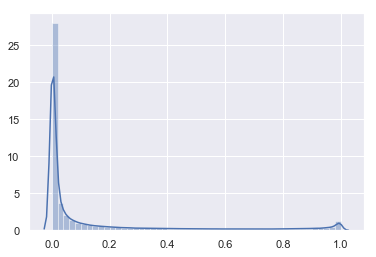

In [107]:
sns.distplot(predictions_lgb)

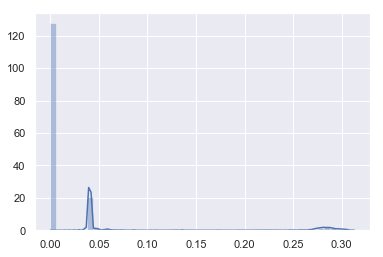

In [156]:
sns.distplot(oof_lgb)

In [154]:
train['pred'] = oof_lgb

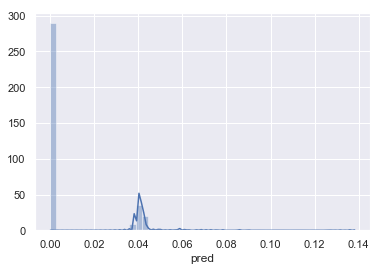

In [157]:
sns.distplot(np.around(train[train.ID_code.isin(bbiggu_idx)][['target', 'pred']].pred, 4))

# Idea

* 한번 후처리해보기

In [81]:
bbiggu['target'] = train.target

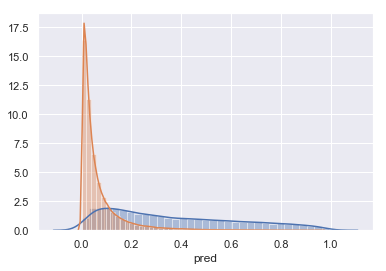

In [84]:

sns.distplot(bbiggu[bbiggu.target == 1].pred)
sns.distplot(bbiggu[bbiggu.target == 0].pred)

In [94]:
bbiggu.loc[(bbiggu.target == 0) & (bbiggu.pred >= 0.1), 'bbiggu'] = 1

# Idea

* 한번 Predict 한걸 기준으로 sorting

In [132]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import xgboost as xgb
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()
sns.set()

In [130]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

In [ ]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.shape, test.shape

In [136]:
bbiggu = pd.read_csv('./data_temp/bbiggu_1.csv')

In [138]:
bbiggu['target'] = train.target

In [143]:
bbiggu.loc[bbiggu.pred <= 0.1, 'pred'] = 0
bbiggu.loc[bbiggu.pred > 0.1, 'pred'] = 1

In [146]:
train.target = bbiggu.pred

In [26]:
col_list = train.columns[2:]

In [147]:
train_0 = train[train.target == 0].copy()
train_1 = train[train.target == 1].copy()

In [148]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0.0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,1.0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.

In [149]:
for col in tqdm_notebook(col_list):
    train_0[col] = train_0[col].sort_values().values
    train_1[col] = train_1[col].sort_values().values

In [150]:
train = train_0.append(train_1).sort_index()

In [151]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0.0,0.4084,-15.0434,2.1171,0.0162,5.0748,-30.6816,2.3473,5.3497,-9.9911,4.1624,-20.7313,-26.0950,13.4884,-6.0111,1.1690,13.0769,0.6351,-33.3802,-9.8861,-11.5576,-5.4322,-10.0890,-5.1640,1.2442,-0.6784,12.7260,-24.0160,-6.1668,2.0896,-4.7872,-34.7984,2.1406,-8.9861,1.5085,9.8238,-16.5136,-8.0951,-0.8878,-5.9082,-14.5457,-35.2117,-8.5359,8.9648,10.6571,-9.9396,-90.2525,1.2062,-47.6862,-23.9022,-8.0707,10.5073,-15.0462,-24.7214,3.3449,-26.7786,-3.7826,3.4762,3.5258,-12.6009,6.1840,-2.1006,-48.8027,-6.3289,-10.5544,1.6117,-14.0888,1.3368,-17.7479,4.9938,-16.0995,-17.0275,-0.2201,-11.8723,-1.6658,-34.1015,-1.2936,-20.9244,7.4257,-1.8183,10.4454,-18.0422,7.5865,-30.0266,-24.2201,-24.4398,7.5869,-18.1250,-8.4816,1.5868,-8.3123,-61.7180,6.5218,-0.9188,8.4916,2.8190,-2.4324,-12.1539,-21.7400,-0.4328,-7.2806,-39.1791,0.0757,-7.3829,0.9793,4.0846,0.7153,0.9424,-5.8980,13.7290,5.7697,-9.2398,2.1942,-2.0302,-5.5139,-0.0505,-6.8586,-2.9290,-30.5794,-37.5277,-9.7742,-18.6962,6.3558,-15.1321,-12.4059,-7.0538,11.4994,11.2654,-8.2108,-11.7559,2.3998,9.5283,-0.9548,2.8900,5.3593,-22.8298,-30.2202,-9.9493,-9.0199,-16.4684,-21.2743,-15.4595,-16.6937,-7.1080,2.8068,5.5935,-8.2734,0.4274,-29.8023,3.3205,-41.1683,9.2420,-1.8884,-2.8800,11.0308,-7.1592,-21.8409,9.9965,-22.7282,-4.5544,-4.6416,-7.4522,4.8526,0.6231,-6.5317,-19.9977,4.1150,1.8848,-35.9695,-5.2502,4.2588,-14.2289,-19.7811,-11.4533,-22.7487,-2.9953,3.2415,-29.1165,4.9521,-29.2734,-7.3445,-22.0374,5.5273,-26.0011,-4.6761,-18.4897,-22.5833,-3.0223,-46.5981,4.4652,-2.5543,-14.0933,-2.6917,-3.8145,-10.8455,8.6944,-5.2610,-14.2096,5.9606,6.6448,-38.8528
1,train_1,1.0,0.4528,-13.8674,2.5825,-0.0402,5.8762,-32.5626,2.4960,5.7494,-10.5055,3.9705,-19.4439,-24.8757,13.4346,-4.9661,1.0133,13.2853,1.0289,-28.9739,-10.6642,-12.4025,-3.3711,-8.4959,-5.3225,1.2098,-0.1905,12.7200,-24.2431,-5.5992,3.0700,-3.8431,-33.5249,2.5031,-8.0843,1.8655,9.8169,-15.0152,-7.9080,-1.1834,-6.3371,-12.8086,-33.5438,-6.6019,8.8590,10.6528,-9.6796,-82.2573,2.0119,-43.1056,-22.7633,-7.6722,10.3855,-13.2473,-20.9729,3.6469,-24.4123,-2.9454,2.7618,3.4423,-11.4144,6.5184,-0.1661,-47.7779,-5.3786,-10.4068,1.7679,-12.7267,2.0337,-19.5443,4.9979,-16.3094,-10.4118,-0.2240,-12.3834,0.7666,-32.8139,-0.6909,-21.6333,7.8664,-0.5381,10.7963,-16.7045,7.9972,-28.5685,-21.0858,-23.0145,7.0230,-19.2722,-7.9873,1.3502,-9.6014,-60.1727,6.5249,-1.0185,8.5204,3.0756,-2.2624,-12.1584,-21.6672,-0.6035,-7.1508,-38.7246,0.5187,-7.0091,0.9892,4.6841,1.0279,1.56

In [33]:
target = train['target']

In [152]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [153]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.836088	valid_1's auc: 0.819334
Early stopping, best iteration is:
[468]	training's auc: 0.828686	valid_1's auc: 0.819566


KeyboardInterrupt: 